In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import input_functions as inp
from input_functions.funcs import connect_graph

In [136]:
k = 20
centers = []
for n in range(k):
    centers.append(((np.random.rand()-.5)*100, (np.random.rand()-.5)*100))
    
xspans, yspans = [], []
for n in range(k):
    xspans.append(np.random.rand()*10)
    yspans.append(np.random.rand()*10)

In [137]:
from input_functions.funcs import generate_clustered_graph

In [138]:
numberofnodes = 200
nodes = [int(x) for x in np.linspace(0, numberofnodes-1, numberofnodes)]
nhomes = 1 #nhomes +1
homes = np.random.choice(nodes, nhomes, replace = False)

G, v, dropoff = generate_clustered_graph(k, numberofnodes, centers,xspans, yspans, maxconnections = 15)
dropoff = np.concatenate((np.array([homes[0]]), dropoff))

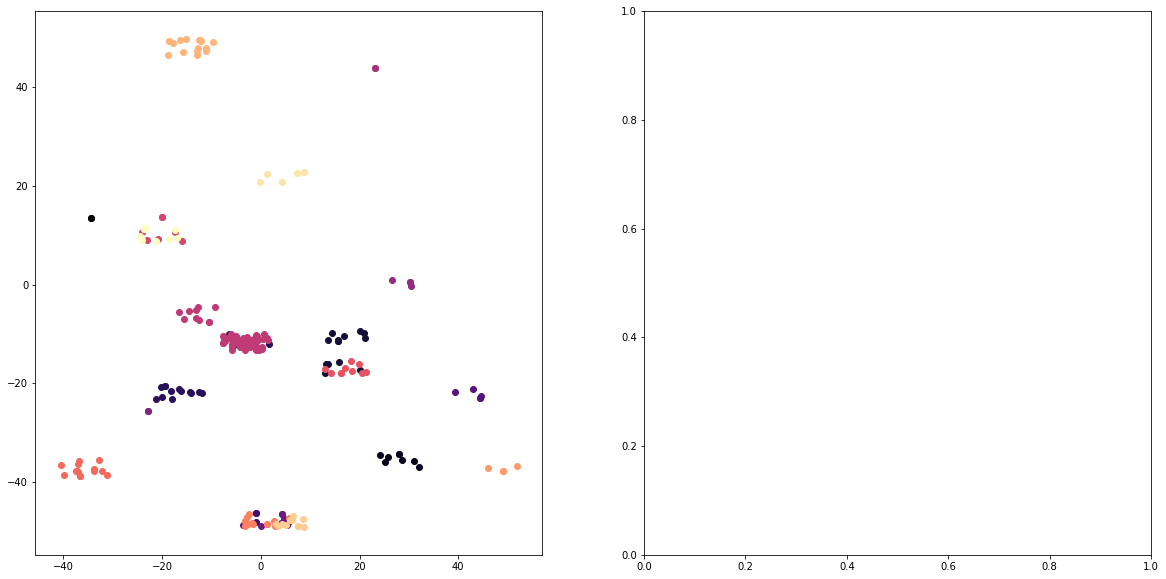

In [141]:
fig, axs = plt.subplots(ncols = 2, figsize = (20,10))

ax = axs[0]

pos = dict()
for i, vi in enumerate(v):
    pos.update({i:vi})
#nx.draw_networkx_nodes(G, pos, ax = ax, alpha = .5, node_size = 50, s = .2)
#nx.draw_networkx_edges(G, pos, ax = ax)

clusters = k_cluster(G, 20)
from matplotlib import cm

colors = [cm.magma(x) for x in np.linspace(0,1,len(clusters))]

for i, clu in enumerate(clusters):
    ax.scatter(v[clusters[clu]][:,0], v[clusters[clu]][:,1], color = colors[i])
#ax.scatter(v[dropoff][:,0], v[dropoff][:,1], color = 'red', s = 500)

In [1]:
def k_cluster(G, k):
    """returns k clusters from the graph G via the method described in class:
    
    randomly selects a starting vertex and then places k vertices at points furthest away from all cluster centers. 
    then assigns all remaining points to the cluster center closest to each point. 
    
    ideas for improvement:
    1. don't assign all points to clusters, choose some radius to which, if a point is that far away from a cluster center,
        then it is assigned to that cluster otherwise none. 
    2. some metric to guess how many clusters, look at degree of clustering possibly
    """

    used = set()
    startnode = np.random.choice(G.nodes, 1)[0]
    used.update({startnode})
    lens = nx.shortest_path_length(G, startnode, weight = 'weight')

    nused = 1
    for j in range(k-1):
        mind = dict()
        for node in G.nodes:
            if node in used:
                continue
            #for each node, find the min distance to the used nodes. then take the max of this put this in a new cluster
            ltoused = [nx.dijkstra_path_length(G, node, nodex) for nodex in used]
            mind.update({node:min(ltoused)})
        #key of the furtherest away i.e. the node furthest away
        newnode = max(mind, key=mind.get)
        used.update({newnode})
        nused+=1

    out = dict()
    for u in used:
        out.update({u:[u,]})
    #now put all nodes in appropriate cluster:
    for node in G.nodes:
        l=nx.shortest_path_length(G, node, weight = 'weight')
        d = np.inf
        for u in used:
            le = l[u]
            if le < d:
                d = le
                clustercenter = u
        out[clustercenter].append(node)

    return out

In [120]:
k_cluster(G, 2)

{3: [3, 0, 1, 2, 3, 4],
 19: [19, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}